In [1]:
import os
os.chdir("/home/arne/devel/PycharmProjects/recursive-dependency-embedding")
from __future__ import print_function
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import spacy
import preprocessing
#from preprocessing import read_data, read_data2, string_reader, get_word_embeddings, process_sentence2, process_sentence3, process_sentence4, addMissingEmbeddings
import constants
from IPython.display import Image
from visualize import visualize, visualize2, getFromVocs
import tools

In [3]:
nlp = spacy.load('en')
nlp.pipeline = [nlp.tagger, nlp.parser]
print('extract word embeddings from spaCy...')
vecs, mapping = preprocessing.get_word_embeddings(nlp.vocab)
# for processing parser output
data_maps = {constants.WORD_EMBEDDING: mapping}
data_maps2 = mapping
# data vectors
data_vecs = {constants.WORD_EMBEDDING: vecs}

extract word embeddings from spaCy...
Total time running get_word_embeddings: 6.62728214264 seconds


In [4]:
import operator
def getCounts(seq_data, vocab, vocab_neg, data_maps_reverse):
    data_counts = {}
    for data in seq_data:
        tools.incOrAdd(data_counts, data)
    #print(data_counts)
    
    d = {getFromVocs(vocab, vocab_neg, data_maps_reverse[key]): data_counts[key] for key in data_counts}
    return sorted(d.items(), key=operator.itemgetter(1), reverse=True)

In [5]:
def read_sentence(sentence, vis = False):
    seq_data, seq_types, seq_parents, seq_edges = read_data(preprocessing.string_reader, nlp, data_maps, args={'content': sentence})
        
    data_maps_reverse = {}
    for key in data_maps:
        data_maps_reverse[key] = tools.revert_mapping(data_maps[key])
        
    if vis == True:
        visualize('forest_temp.png', (seq_data, seq_types, seq_parents, seq_edges), data_maps_reverse, nlp.vocab)
        img = Image('forest_temp.png')
        display(img)
   
    return seq_data, seq_types, seq_parents, seq_edges


def read_sentence2(sentence, vis = False):
    seq_data, seq_parents, root = preprocessing.read_data2(preprocessing.string_reader, preprocessing.process_sentence5, nlp, data_maps2, args={'content': sentence})
    print('root: '+ str(root))
    
    data_maps_reverse = tools.revert_mapping(data_maps2)
    
    print('counts: '+str(getCounts(seq_data, nlp.vocab, constants.vocab_manual, data_maps_reverse)))
    #print('counts: ' + str(tools.getFromDicts(nlp.vocab, constants.vocab_manual,)))
    
        
    
        
    if vis == True:
        visualize2('forest_temp.png', (seq_data, seq_parents), data_maps_reverse, nlp.vocab, constants.vocab_manual)
        img = Image('forest_temp.png')
        display(img)
   
    return seq_data, seq_parents, root

In [6]:
sorted(data_maps2.values())[-10:]
len(sorted(data_maps2.values()))

1297613

add to dict: 365 -> 1297613
add to dict: 367 -> 1297614
add to dict: 393 -> 1297615
add to dict: 380 -> 1297616
root: 20
counts: [(u'nsubj', 2), (u'.', 2), (u'punct', 2), (u'dobj', 2), (u'ROOT', 2), (u'amod', 2), (u'A', 1), (u'this', 1), (u'arts', 1), (u'practicing', 1), (u'monkey', 1), (u'I', 1), (u'shy', 1), (u'is', 1), (u'advmod', 1), (u'det', 1), (u'martial', 1), (u'very', 1), (u'aux', 1), (u'like', 1)]


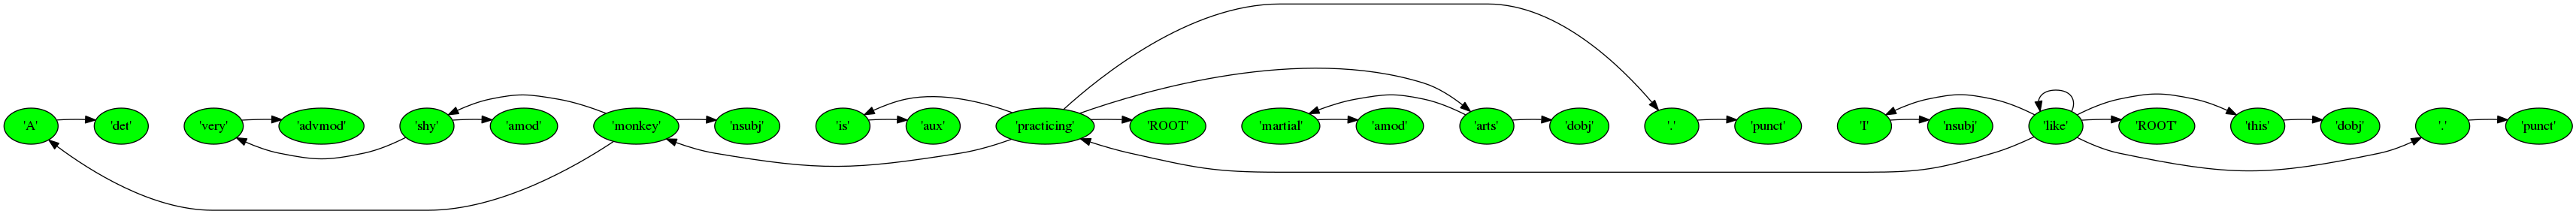

[    291      48     234 1297613    5132 1297614    6313 1297615     117
      44    5593   53146    7686 1297614    5353 1297616      70      62
     110 1297615     145   53146     139 1297616      70      62]
[ 6 -1  2 -1  2 -1  4 -1  2 -1 10 -1  2 -1 -4 -1 -6 -1  2 -1  0 -1 -2 -1 -4
 -1]


In [7]:
(seq_data, seq_parents, root) = read_sentence2('A very shy monkey is practicing martial arts. I like this.', True) 
#new_embeddings, added_count = addMissingEmbeddings(seq_data, vecs)
#new_embeddings, added_count = addMissingEmbeddings(seq_data, new_embeddings)
#vecs = new_embeddings

print(seq_data)
print(seq_parents)

In [7]:
from preprocessing import build_sequence_tree, children_and_roots
children, roots = children_and_roots(seq_parents)
seq_tree = build_sequence_tree(seq_data, children, root)
seq_tree

head: 145
children {
  head: 5593
  children {
    head: 6313
    children {
      head: 291
      children {
        head: 48
      }
    }
    children {
      head: 5132
      children {
        head: 234
        children {
          head: 1297613
        }
      }
      children {
        head: 1297614
      }
    }
    children {
      head: 1297615
    }
  }
  children {
    head: 117
    children {
      head: 44
    }
  }
  children {
    head: 53146
  }
  children {
    head: 5353
    children {
      head: 7686
      children {
        head: 1297614
      }
    }
    children {
      head: 1297616
    }
  }
  children {
    head: 70
    children {
      head: 62
    }
  }
}
children {
  head: 110
  children {
    head: 1297615
  }
}
children {
  head: 53146
}
children {
  head: 139
  children {
    head: 1297616
  }
}
children {
  head: 70
  children {
    head: 62
  }
}

In [8]:
import tensorflow_fold as td
import tensorflow as tf



In [12]:
embeds = td.Embedding(10000, 300, name='head_embed')

x = sequence_tree_block(300, embeds)
x.eval(seq_tree)
#seq_tree

AttributeError: 'ForwardDeclaration' object has no attribute 'eval'

In [12]:
import tensorflow_fold as td
import tensorflow as tf

lex_size = 5
state_size = 10

expr_decl = td.ForwardDeclaration(td.PyObjectType(), state_size)

# get the head embedding from id
def head(name_):
     return td.Pipe(td.Scalar(dtype='int32'), 
               td.Function(td.Embedding(lex_size, state_size, name='head_embed')), 
               name=name_)
# get the weighted sum of all children
def children_aggr(name_):
     return td.Pipe(td.Map(expr_decl()), 
                        td.Map(td.Function(lambda x: tf.norm(x) * x)), 
                        td.Reduce(td.Function(tf.add)), 
                        name=name_)

#dummy = td.con

gru_cell = td.ScopedLayer(tf.contrib.rnn.GRUCell(num_units=state_size), 'mygru')

#def aggr_op():
#    return (td.Record([('head', head), ('children', children_aggr)]) >>
#              td.Concat() >>
#              td.FC(state_size, name='FC_aggr'))
    #return ([children_aggr] >> td.RNN(gru_cell, initial_state=head))
    #return (children_aggr)

def cas(seq_tree):    
    # process and aggregate
    if len(seq_tree['children']) > 0 and seq_tree['head'] is not None:
        return 0
    # dont process children
    if len(seq_tree['children']) == 0:
        return 1
    # process children only
    return 2
    
    
cases = td.OneOf(lambda x: cas(x),
                     {1: td.Record([('head', head('head') >> td.Broadcast()), ('children', children_aggr('children_aggr') >> td.Broadcast())]) 
                      >> td.Zip() 
                      >> td.Reduce(td.Function(tf.add)), #td.RNN(gru_cell, initial_state_from_input=True),
                      2: td.GetItem('head') >> td.Optional(head('just_head')),
                      3: td.GetItem('children') >> children_aggr('just_children')})


expr_decl.resolve_to(cases)

In [ ]:
cases2 = td.OneOf(lambda x: cas(x),
                     {1: td.Record([('head', head('head') >> td.Broadcast()), ('children', children_aggr('children_aggr') >> td.Broadcast())]) 
                      >> td.Zip() 
                      >> td.Reduce(td.Function(tf.add)), #td.RNN(gru_cell, initial_state_from_input=True),
                      2: td.GetItem('head') >> td.Optional(head('just_head'))})

In [25]:
import numpy as np
def calc_embedding_avg(seq):
    seq_data, seq_types, seq_parents, seq_edges = seq
    e = np.zeros(nlp.vocab.vectors_length) # TODO: check dim of embeddings!
    for i in range(len(seq_data)):
        e += data_vecs[seq_types[i]][seq_data[i]]
    return e / len(seq_data) # average

In [26]:
calc_embedding_avg(read_sentence('A very shy monkey is practicing martial arts.'))

array([  1.07410002e-02,   1.04797661e-01,  -9.15853009e-02,
        -5.72742199e-02,   1.87026666e-01,  -2.82920011e-02,
         3.37927755e-02,  -1.95071244e-01,  -3.40955622e-03,
         2.12087999e+00,  -1.69830299e-01,   1.09519947e-02,
        -6.34260000e-02,  -1.11622448e-01,  -1.12552635e-02,
         1.59957554e-01,   1.04001443e-01,   8.65459439e-01,
        -2.38412996e-01,   5.50149985e-02,  -7.51673329e-02,
        -1.80346219e-01,  -8.34840544e-02,  -1.11868726e-01,
         8.09453333e-02,  -6.86778910e-02,  -1.04682251e-02,
        -4.30825555e-02,   6.12711095e-02,  -2.60911190e-01,
        -4.86684436e-02,   4.19144664e-03,   1.84042576e-01,
        -2.16793002e-01,   1.31033664e-01,  -8.43688916e-02,
         6.11080002e-02,  -5.91083342e-02,  -1.17230153e-01,
        -3.09220557e-01,   1.51952467e-01,   1.42462335e-01,
         1.21541668e-01,  -3.40155537e-02,   2.18288891e-01,
         2.27417561e-01,  -7.52422234e-02,   5.98678859e-02,
        -1.67224473e-02,

In [29]:
doc = nlp(u"Apples and oranges are ASdjkhaksdhkahd. Boots and hippos aren't.")

apples = doc[0]
oranges = doc[2]
boots = doc[6]
hippos = doc[8]

In [31]:
doc[4].orth

1510419

In [32]:
doc2 = nlp(u"Hello you ASdjkhaksdhkahd.")
doc2[2].orth

1510419

In [33]:
len(doc.vocab)

1297627

In [ ]:
#TODO: